# Causal analysis of confinment actions
This notebook contains the preliminary analysis made on the data, which is then implemented in the dashboard.

In [1]:
library(ggplot2)
library(repr) # For changing the size of the plot

In [2]:
counts.df <- readRDS("data/COVID19_Global_Italy_wGrowth.Rdata")
country.df <- readRDS("data/COVID19_Country_Info.Rdata")

In [3]:
head(counts.df)

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Recovered,Deaths,HospitalizedWSymptoms,ICU,⋯,DailyConfirmed,Total,Tests,Lat.x,Long.x,Lat.y,Long.y,ConfirmedGrowthRate,RecoveredGrowthRate,DeathsGrowthRate
,<chr>,<chr>,<dbl>,<dbl>,<date>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,,Afghanistan,33,65,2020-01-22,0,0,0,NA,NA,⋯,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
23,,Afghanistan,33,65,2020-01-23,0,0,0,NA,NA,⋯,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
24,,Afghanistan,33,65,2020-01-24,0,0,0,NA,NA,⋯,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
25,,Afghanistan,33,65,2020-01-25,0,0,0,NA,NA,⋯,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
26,,Afghanistan,33,65,2020-01-26,0,0,0,NA,NA,⋯,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
27,,Afghanistan,33,65,2020-01-27,0,0,0,NA,NA,⋯,NA,NA,NA,33,65,33,65,NaN,NaN,NaN


In [4]:
head(country.df)

,Country.Region,Date.Schools,Date.Public Places,Date.Gatherings,Date.Stay at Home,Date.Lockdown,Date.Non-essential,pop,tests,testpop,⋯,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Alabama,3/18/2020,3/20/2020,NA,NA,NA,NA,,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Alaska,3/16/2020,3/18/2020,3/24/2020,NA,NA,NA,,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Argentina,NA,NA,NA,3/20/2020,NA,NA,"45,195,774",NA,NA,⋯,1.05,1.06,1.05,1,0.94,0.71,0.98,29.27,20.16,42.59
4,Arizona,3/16/2020,3/20/2020,NA,NA,NA,NA,,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Arkansas,3/17/2020,NA,NA,NA,NA,NA,,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,Atlanta,NA,3/19/2020,NA,NA,NA,NA,,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Comparison of before / after distributions
### Make sure we have dates in date format, not character

In [5]:
for (colname in c("Date.Schools", "Date.Public Places", "Date.Gatherings", "Date.Stay at Home", "Date.Lockdown", "Date.Non-essential")) {
    country.df[,colname] <- as.Date(country.df[,colname], format="%m/%d/%y")
}

### Create the dataframe for plotting
This dataframe contains one row for each original row and for each action, along with a logical column indicating whether this day was before or after the action, and a column with the name of the action. So by subsetting the dataframe by action name, we have a clean view of before / after distribution, easy to plot with ggplot2.

In [92]:
to_long_format_on_action <- function(counts.df, country.df) {
    actions <- c("Date.Schools", "Date.Public Places", "Date.Gatherings", "Date.Stay at Home", "Date.Lockdown", "Date.Non-essential")
    res.df <- do.call("rbind", lapply(unique(counts.df$Country.Region), function(country) {
        do.call("rbind", lapply(actions, function(action) {
            action_date <- country.df[country.df$Country.Region == country, action]
            # If we have no date for the given action in this country
            if (length(action_date) != 1)
                return(NULL)
            country_counts.df <- counts.df[counts.df$Country.Region == country,]
            country_counts.df$BeforeAction <- country_counts.df$Date <= action_date
            country_counts.df$Action <- action
            return(country_counts.df)
        }))
    }))
    res.df <- res.df[!is.na(res.df$BeforeAction),]
    return(res.df)
}

actions.df <- to_long_format_on_action(counts.df, country.df)
actions.df <- actions.df[is.finite(actions.df$ConfirmedGrowthRate),]

# Subset italy
to_plot.df <- actions.df[(actions.df$Country.Region == "Italy") & (actions.df$Province.State == ""),]

### Plot

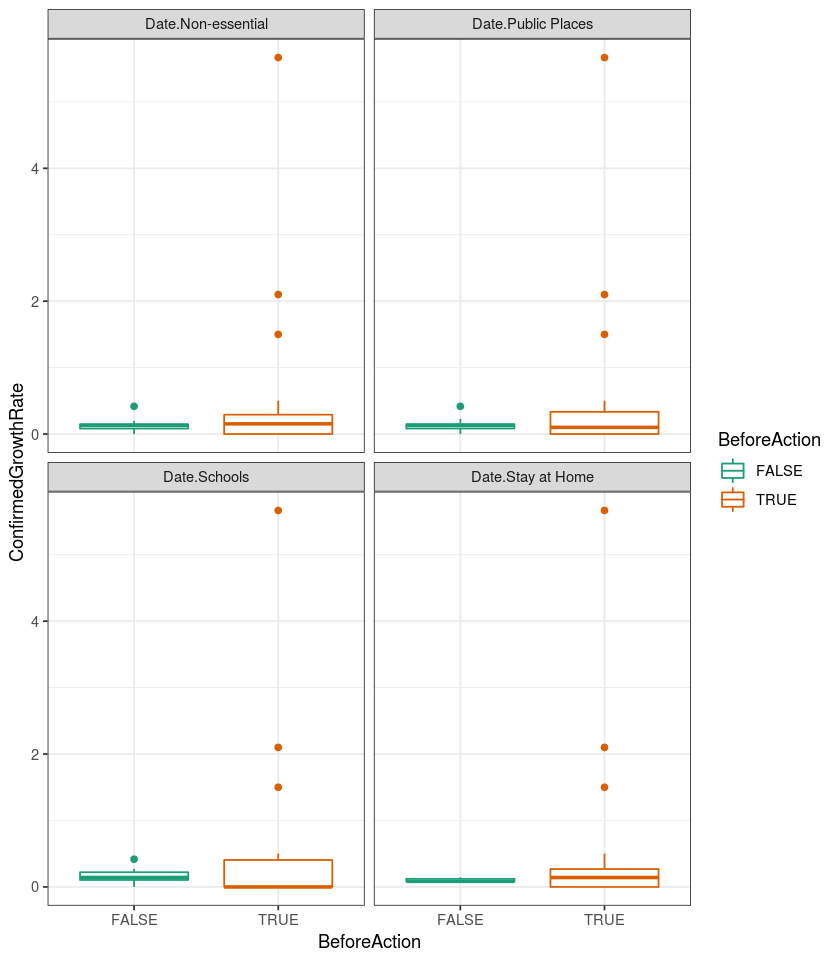

In [93]:
options(repr.plot.width=7, repr.plot.height=8)
ggplot(to_plot.df, aes(x = BeforeAction, color = BeforeAction, y = ConfirmedGrowthRate)) + 
    geom_boxplot() +
    facet_wrap(~ Action) +
    theme(text = element_text(size=50)) +
    scale_color_brewer(type = "qual", palette = 2) +
    theme_bw()

## Statistical test of before / after distributions
### QQ-plot, to check the normal hypothesis of the growth rate

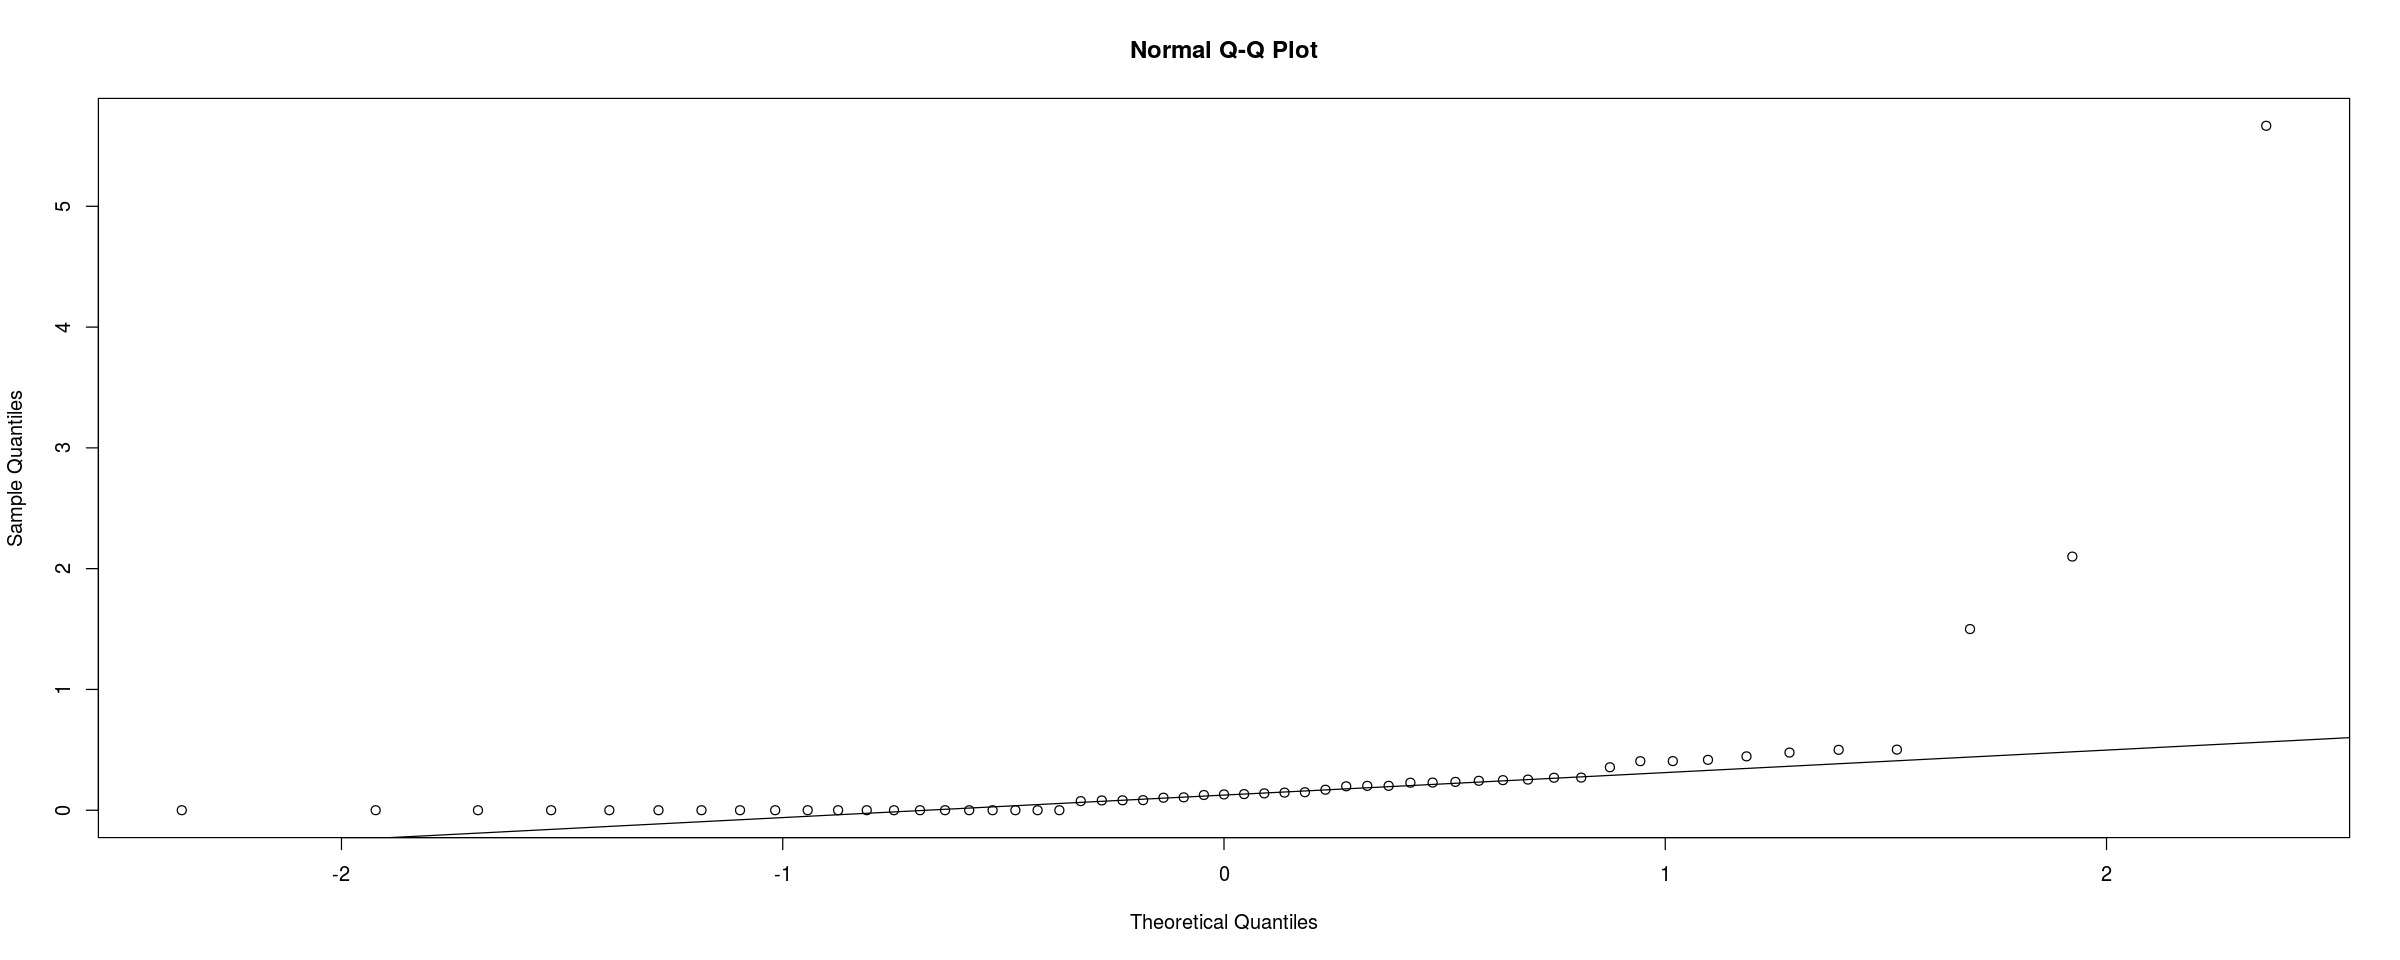

In [12]:
data <- counts.df[counts.df$Country.Region == country,]
qqnorm(data$ConfirmedGrowthRate[is.finite(data$ConfirmedGrowthRate)])
qqline(data$ConfirmedGrowthRate[is.finite(data$ConfirmedGrowthRate)])

Ok, its not really compliant with the hypothesis, but we'll go with it for now.
### Z-test
We first define a function to make the z test in all countries and on all action measures at the same time.

In [157]:
rename_col <- function(df, old, new) {
    names(df)[names(df) == old] <- new
    df
}

compute_z_statistic <- function(actions.df, value_column) {
    # Create a list of dataframes, for each of these three functions.
    # Each resulting dataframe contains a column with the result of applying
    # the function for each country, province, action and whether we are before or after the action
    aggregates.list <- lapply(list(list(fn = mean, fn_name = "Mean"),
                                   list(fn = length, fn_name = "Length"),
                                   list(fn = sd, fn_name = "Sd")),
        function(func_pair) {
            results <- aggregate(x = actions.df[,value_column],
                                 by = list(Country.Region = actions.df$Country.Region,
                                           Province.State = actions.df$Province.State,
                                           BeforeAction = actions.df$BeforeAction,
                                           Action = actions.df$Action),
                                 FUN = func_pair$fn)
            # Aggregate names the new column "x", so we rename it properly
            names(results)[names(results) == "x"] <- paste0(value_column, func_pair$fn_name)
            return(results)
        })
    
    # Merge the three dataframes, so we have one column per relevant statistic
    results <- merge(aggregates.list[[1]],
                     merge(aggregates.list[[2]],
                           aggregates.list[[3]],
                           by=c("Country.Region", "Province.State", "BeforeAction", "Action")),
                     by=c("Country.Region", "Province.State", "BeforeAction", "Action"))
    
    # Convert to wide format, so that we have the statistic before and after the action in separate columns
    results <- reshape(results,
                       idvar = c("Country.Region", "Province.State", "Action"),
                       timevar = "BeforeAction",
                       direction = "wide")

    # Compute the Z statistic
    results$Z <- (results[,paste0(value_column, "Mean.FALSE")] - results[,paste0(value_column, "Mean.TRUE")]) /
            ((results[,paste0(value_column, "Sd.FALSE")] / results[,paste0(value_column, "Length.FALSE")]) -
             (results[,paste0(value_column, "Sd.TRUE")] / results[,paste0(value_column, "Length.TRUE")]))
    return(results[, c("Country.Region", "Province.State", "Action", "Z")])
}

Now we can run the function, and compute the one-sided p-value for it, after adjustment using Holm's method.

In [178]:
z_stat <- compute_z_statistic(actions.df[actions.df$Province.State == "",], "ConfirmedGrowthRate")
z_stat$p.value <- 1 - pnorm(z_stat$Z, 0, 1)
z_stat$p.value.adj <- p.adjust(z_stat$p.value)

Plot 1 minus the p value, to clearly differentiate missing cases (no p value) from p value close to zero.

Warning message:
“Removed 3 rows containing missing values (position_stack).”


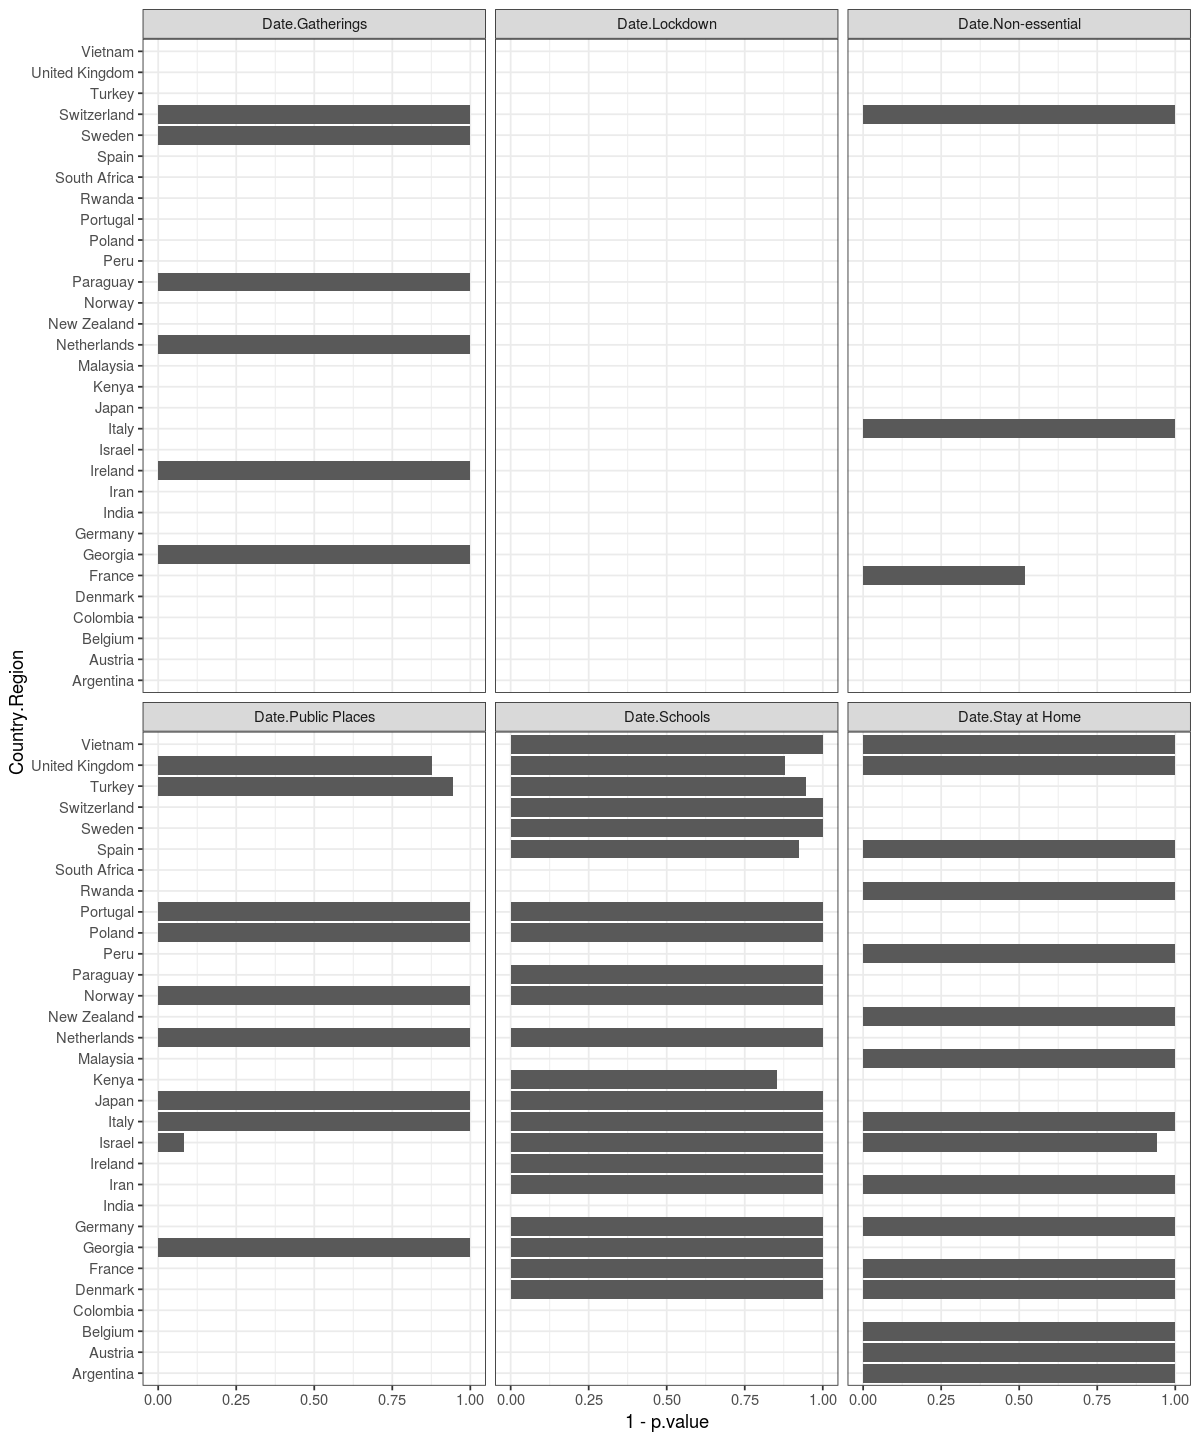

In [180]:
options(repr.plot.width=10, repr.plot.height=12)
ggplot(z_stat, aes(x = Country.Region, y = 1 - p.value)) + geom_col() +
    facet_wrap(~ Action) +
    coord_flip() +
    theme(text = element_text(size=60)) +
    scale_color_brewer(type = "qual", palette = 2) +
    theme_bw()